# Day26 Category Overlay Sweep

Generate overlay grids for every smoothing window discovered under the configured figure parent directory. The notebook auto-discovers window names (e.g., `gauss_10p00`, `none_0p00`), collects per-category plots, and saves a separate overlay PNG for each window. Adjust the configuration cell and run the final cell to regenerate overlays.

In [ ]:

from pathlib import Path
from math import ceil
from typing import List, Sequence, Tuple

from PIL import Image
import matplotlib.pyplot as plt

# --- Configuration ---

PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE')
#PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_CAE_detrend_moving_average_CAE')
#PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_gaussian_rho')
#PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_rho_detrend_moving_average_rho')
#PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_lasso_cli_90_detrend_gaussian')
#PARENT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs/UTS01/wheretheressmoke/day26_ridge_cli_90_detrend_gaussian')

PLOT_SUFFIX = 'rho_progression'
CATEGORY_PREFIX = 'cat_'
NUM_COLUMNS = 3

SUBJECT_OVERRIDE = None
STORY_OVERRIDE = None

# What counts as a window directory
VALID_WINDOW_PREFIXES = ('none_', 'movavg_', 'gauss_')
    

In [2]:
# --- Helpers ---

def infer_subject_story(parent_dir: Path) -> Tuple[str, str]:
    try:
        idx = parent_dir.parts.index('figs_new')
    except ValueError as exc:
        raise ValueError("Unable to locate 'figs_new' in the parent directory path.") from exc
    try:
        return parent_dir.parts[idx + 1], parent_dir.parts[idx + 2]
    except IndexError as exc:
        raise ValueError("Parent directory must include subject and story segments after 'figs_new'.") from exc


def resolve_story_dirs(base_dir: Path, story: str) -> List[Path]:
    if not base_dir.exists():
        return []
    direct = base_dir / story
    if direct.is_dir():
        return [direct]
    dirs = [path for path in sorted(base_dir.iterdir()) if path.is_dir()]
    matches = [
        path for path in dirs
        if path.name.startswith(f"{story}_") or path.name.startswith(f"{story}-")
    ]
    if matches:
        return matches
    matches = [path for path in dirs if story in path.name]
    if matches:
        return matches
    if len(dirs) == 1:
        return dirs
    return []


def discover_windows(parent_dir: Path, category_prefix: str) -> List[str]:
    windows = set()
    for category_dir in sorted(parent_dir.iterdir()):
        if not category_dir.is_dir() or not category_dir.name.startswith(category_prefix):
            continue
        for child in category_dir.iterdir():
            if not child.is_dir():
                continue
            if child.name.startswith(VALID_WINDOW_PREFIXES):
                windows.add(child.name)
    return sorted(windows)


def collect_category_images_for_window(
    parent_dir: Path,
    window: str,
    plot_suffix: str,
    category_prefix: str,
    subject: str,
    story: str,
) -> Tuple[Sequence[Tuple[str, Path]], Sequence[Path]]:
    discovered = []
    missing = []

    for category_dir in sorted(parent_dir.iterdir()):
        if not category_dir.is_dir() or not category_dir.name.startswith(category_prefix):
            continue

        category_label = category_dir.name.rstrip('_')
        subject_dir = category_dir / window / subject
        story_dirs = resolve_story_dirs(subject_dir, story)
        image_path = None

        for story_dir in story_dirs:
            candidate = (
                story_dir
                / 'day22_category_mde'
                / 'plots'
                / category_label
                / f'mde_{category_label}_{plot_suffix}.png'
            )
            if candidate.exists():
                image_path = candidate
                break

        if image_path is None:
            fallback_story_dir = story_dirs[0] if story_dirs else subject_dir / story
            missing.append(
                fallback_story_dir
                / 'day22_category_mde'
                / 'plots'
                / category_label
                / f'mde_{category_label}_{plot_suffix}.png'
            )
            continue

        discovered.append((category_label, image_path))

    discovered.sort(key=lambda x: x[0])
    return discovered, missing


def make_overlay_figure(
    window: str,
    plot_suffix: str,
    category_images: Sequence[Tuple[str, Path]],
    num_columns: int,
):
    num_rows = ceil(len(category_images) / num_columns)
    fig, axes = plt.subplots(
        num_rows,
        num_columns,
        figsize=(num_columns * 4.0, num_rows * 3.2),
        squeeze=False,
    )
    axes_iter = axes.flatten()

    for ax in axes_iter:
        ax.axis('off')

    for ax, (category_label, image_path) in zip(axes_iter, category_images):
        with Image.open(image_path) as img:
            ax.imshow(img)
        pretty_label = category_label.replace('cat_', '').replace('_', ' ').title()
        ax.set_title(pretty_label, fontsize=10)

    fig.suptitle(f"{window} · {plot_suffix.replace('_', ' ')}", fontsize=14)
    fig.subplots_adjust(wspace=0.12, hspace=0.28)
    fig.tight_layout(rect=[0, 0, 1, 0.94], pad=0.6)
    return fig



In [3]:
# --- Sweep and save overlays ---

if not PARENT_DIR.exists():
    raise FileNotFoundError(f"PARENT_DIR does not exist: {PARENT_DIR}")

subject, story = infer_subject_story(PARENT_DIR)
if SUBJECT_OVERRIDE:
    subject = SUBJECT_OVERRIDE
if STORY_OVERRIDE:
    story = STORY_OVERRIDE

print(f'Parent directory : {PARENT_DIR}')
print(f'Subject/story    : {subject}/{story}')
print(f'Plot suffix      : {PLOT_SUFFIX}')

windows = discover_windows(PARENT_DIR, CATEGORY_PREFIX)
if not windows:
    raise ValueError('No smoothing windows found under the category directories.')

print(f"Discovered windows ({len(windows)}):")
for w in windows:
    print(f"  - {w}")

saved_paths = []

for window in windows:
    print(f"\nProcessing window: {window}")
    category_images, missing_images = collect_category_images_for_window(
        PARENT_DIR,
        window,
        PLOT_SUFFIX,
        CATEGORY_PREFIX,
        subject,
        story,
    )

    print(f"  Located {len(category_images)} plot(s).")
    if missing_images:
        print(f"  Missing {len(missing_images)} plot(s) for this window (showing up to 5):")
        for p in missing_images[:5]:
            print(f"    - {p}")

    if not category_images:
        print('  No plots found for this window; skipping overlay.')
        continue

    fig = make_overlay_figure(window, PLOT_SUFFIX, category_images, NUM_COLUMNS)

    output_filename = f"{window}_{PLOT_SUFFIX}_overlay.png"
    output_path = PARENT_DIR / output_filename
    output_path.parent.mkdir(parents=True, exist_ok=True)

    fig.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    saved_paths.append(output_path)
    print(f"  Saved overlay to: {output_path}")

print('\nDone.')
print(f"Saved {len(saved_paths)} overlay(s).")
for p in saved_paths:
    print(f"  - {p}")

Parent directory : /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE
Subject/story    : UTS02/wheretheressmoke
Plot suffix      : cae_progression
Discovered windows (5):
  - gauss_10p00
  - gauss_20p00
  - gauss_30p00
  - gauss_40p00
  - none_0p00

Processing window: gauss_10p00
  Located 12 plot(s).
  Saved overlay to: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE/gauss_10p00_cae_progression_overlay.png

Processing window: gauss_20p00
  Located 12 plot(s).
  Saved overlay to: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE/gauss_20p00_cae_progression_overlay.png

Processing window: gauss_30p00
  Located 12 plot(s).
  Saved overlay to: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE/gauss_30p00_cae_progression_overlay.png

Processing window: gauss_40p00
  Located 12 plot(s).
  

# Day26 Category Heatmap Sweep

Build consolidated heatmaps of test metrics (rho, CAE, RMSE) across smoothing windows and semantic categories.

In [4]:
# --- Best-window prediction overlay (one plot per category) ---

import pandas as pd

PREDICTION_OVERLAY_SUFFIX = 'prediction_overlay'


def read_rho_for_window(parent_dir: Path, window: str):
    csv_path = parent_dir / f"{window}_rho_summary.csv"
    if not csv_path.exists():
        return None
    df = pd.read_csv(csv_path)
    if 'rho_test' in df.columns:
        col = 'rho_test'
    elif len(df.columns) >= 3:
        col = df.columns[2]
    else:
        col = df.columns[-1]
    df = df[['category', col]].copy()
    df.rename(columns={col: 'value'}, inplace=True)
    return df


def find_best_windows(parent_dir: Path, window_list):
    best = {}
    for window in window_list:
        rho_df = read_rho_for_window(parent_dir, window)
        if rho_df is None:
            print(f"Skipping window {window}: missing rho summary.")
            continue
        for _, row in rho_df.iterrows():
            cat = str(row['category'])
            val = row['value']
            if pd.isna(val):
                continue
            current = best.get(cat)
            if current is None or val > current[1]:
                best[cat] = (window, float(val))
    return best


def collect_prediction_overlays(parent_dir: Path, best_windows, subject: str, story: str):
    discovered = []
    missing = []
    category_dirs = {
        d.name.rstrip('_'): d
        for d in parent_dir.iterdir()
        if d.is_dir() and d.name.startswith(CATEGORY_PREFIX)
    }
    for cat_key, (window, score) in sorted(best_windows.items()):
        category_dir = category_dirs.get(cat_key)
        if category_dir is None:
            missing.append(f"Missing category directory for {cat_key}")
            continue
        subject_dir = category_dir / window / subject
        story_dirs = resolve_story_dirs(subject_dir, story)
        image_path = None
        for story_dir in story_dirs:
            candidate = (
                story_dir
                / 'day22_category_mde'
                / 'plots'
                / cat_key
                / f"mde_{cat_key}_{PREDICTION_OVERLAY_SUFFIX}.png"
            )
            if candidate.exists():
                image_path = candidate
                break
        if image_path is None:
            fallback_story_dir = story_dirs[0] if story_dirs else subject_dir / story
            missing.append(
                str(
                    fallback_story_dir
                    / 'day22_category_mde'
                    / 'plots'
                    / cat_key
                    / f"mde_{cat_key}_{PREDICTION_OVERLAY_SUFFIX}.png"
                )
            )
            continue
        label = f"{cat_key} ({window}, rho={score:.3f})"
        discovered.append((label, image_path))
    return discovered, missing


try:
    candidate_windows = list(windows)
except NameError:
    candidate_windows = discover_windows(PARENT_DIR, CATEGORY_PREFIX)

best_windows = find_best_windows(PARENT_DIR, candidate_windows)

if not best_windows:
    print("No best windows determined; skipping prediction overlay sweep.")
else:
    print("Best window per category (by rho_test when available):")
    for cat_key, (win, score) in sorted(best_windows.items()):
        print(f"  - {cat_key}: {win} (rho={score:.4f})")

    best_images, missing_overlays = collect_prediction_overlays(PARENT_DIR, best_windows, subject, story)
    if missing_overlays:
        print("Missing prediction overlay files (showing up to 5):")
        for path in missing_overlays[:5]:
            print(f"  - {path}")

    if best_images:
        best_fig = make_overlay_figure('best_per_category', PREDICTION_OVERLAY_SUFFIX, best_images, NUM_COLUMNS)
        best_output_path = PARENT_DIR / "best_prediction_overlay.png"
        best_output_path.parent.mkdir(parents=True, exist_ok=True)
        best_fig.savefig(best_output_path, dpi=200, bbox_inches='tight')
        plt.close(best_fig)
        print(f"Saved best-window prediction overlay to: {best_output_path}")
    else:
        print("No prediction overlay images found to assemble.")


Best window per category (by rho_test when available):
  - cat_abstract: gauss_10p00 (rho=0.3303)
  - cat_communal: gauss_30p00 (rho=0.3184)
  - cat_emotional: gauss_40p00 (rho=0.3308)
  - cat_locational: gauss_30p00 (rho=0.2080)
  - cat_mental: gauss_10p00 (rho=0.3601)
  - cat_numeric: gauss_40p00 (rho=0.3221)
  - cat_professional: gauss_20p00 (rho=0.2764)
  - cat_social: gauss_40p00 (rho=0.5605)
  - cat_tactile: gauss_10p00 (rho=0.5065)
  - cat_temporal: gauss_20p00 (rho=0.5538)
  - cat_violent: gauss_30p00 (rho=0.3375)
  - cat_visual: gauss_30p00 (rho=0.3416)
Saved best-window prediction overlay to: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE/best_prediction_overlay.png


Building heatmap for lag group: default
  - none_0p00
  - gauss_10p00
  - gauss_20p00
  - gauss_30p00
  - gauss_40p00


/scratch/ipykernel_2941607/1648893032.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


Saved heatmap to: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE/day26_mde_per_category_heatmap.png


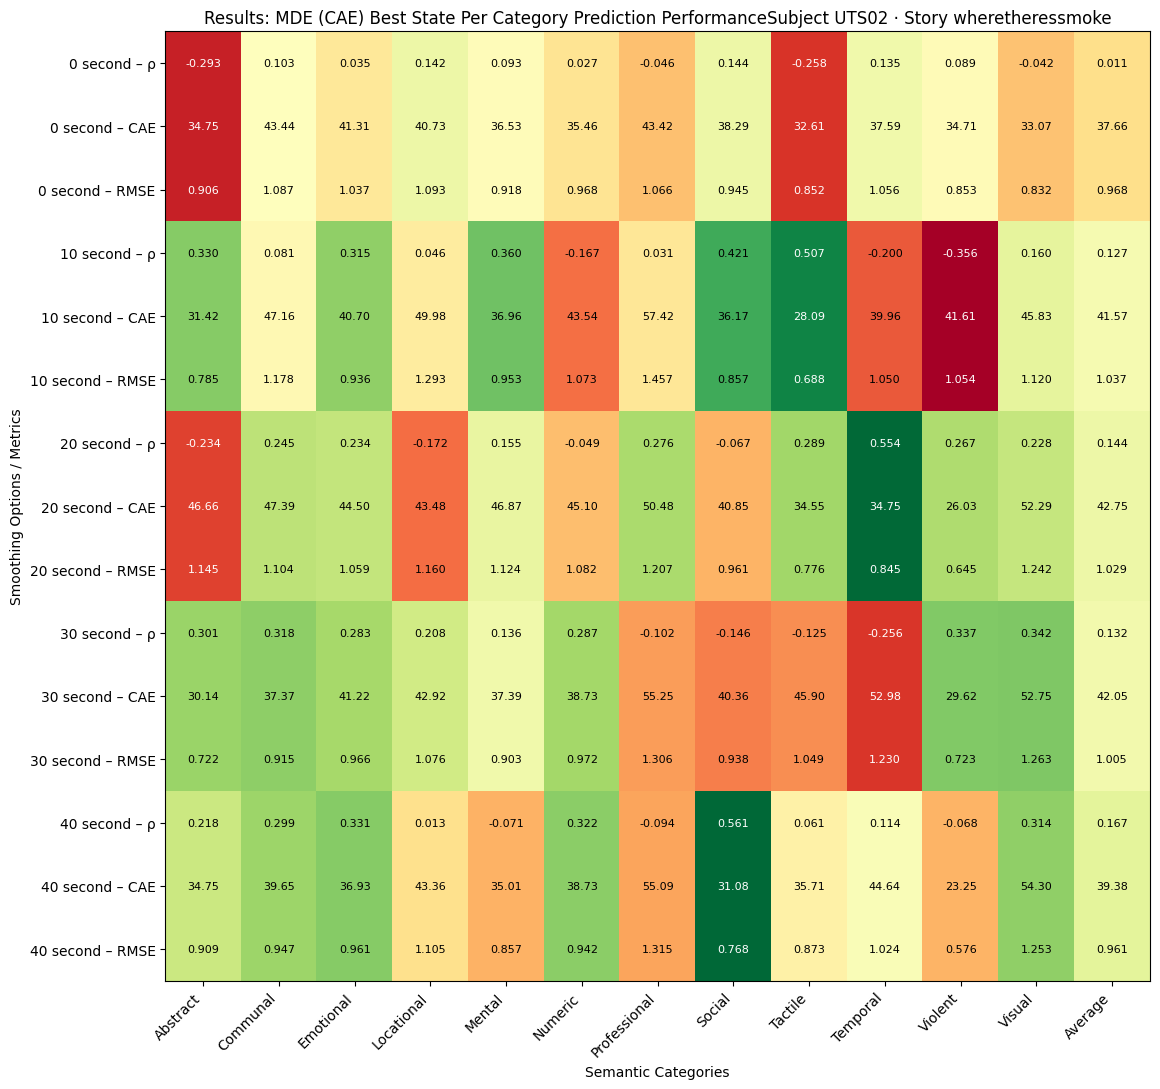

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

CATEGORIES_DISPLAY = [
    'Abstract', 'Communal', 'Emotional', 'Locational', 'Mental', 'Numeric',
    'Professional', 'Social', 'Tactile', 'Temporal', 'Violent', 'Visual'
]
METRIC_CONFIG = [
    ('ρ', 'rho', 'rho_test'),
    ('CAE', 'cae', 'cae_test'),
    ('RMSE', 'rmse', 'rmse_test'),
]
LAG_OPTIONS = ('lag', 'nolag')


def split_window_and_lag(name: str):
    for lag in LAG_OPTIONS:
        suffix = f"_{lag}"
        if name.endswith(suffix):
            return name[: -len(suffix)], lag
    return name, None


def discover_windows_with_lag(parent_dir: Path, valid_prefixes: tuple[str, ...]):
    buckets = {}
    for csv_path in parent_dir.glob('*_rho_summary.csv'):
        base_name = csv_path.name.replace('_rho_summary.csv', '')
        window_base, lag = split_window_and_lag(base_name)
        if not window_base.startswith(valid_prefixes):
            continue
        buckets.setdefault(lag, set()).add(window_base)
    return {lag: sorted(wins, key=window_sort_key) for lag, wins in buckets.items()}


def window_to_seconds_label(window: str) -> str:
    if '_' not in window:
        return window
    numeric_part = window.split('_', 1)[1].replace('p', '.')
    try:
        value = float(numeric_part)
    except ValueError:
        return window
    if value.is_integer():
        value_str = str(int(value))
    else:
        value_str = f"{value:.2f}".rstrip('0').rstrip('.')
    return f"{value_str} second"


def window_sort_key(window: str) -> float:
    if '_' not in window:
        return float('inf')
    numeric_part = window.split('_', 1)[1].replace('p', '.')
    try:
        return float(numeric_part)
    except ValueError:
        return float('inf')


def format_category_name(raw_category: str) -> str:
    return raw_category.replace('cat_', '').replace('_', ' ').title()


def read_metric_csv(csv_path: Path, preferred_test_col: str):
    if not csv_path.exists():
        return None
    df = pd.read_csv(csv_path)
    if preferred_test_col in df.columns:
        col = preferred_test_col
    elif len(df.columns) >= 3:
        col = df.columns[2]
    else:
        col = df.columns[-1]
    df = df[['category', col]].copy()
    df.rename(columns={col: 'value'}, inplace=True)
    return df


def build_metrics_table(parent_dir: Path, windows: list[str], lag: str | None) -> pd.DataFrame:
    rows = []
    index = []

    lag_suffix = f"_{lag}" if lag else ''
    lag_label = f" ({lag.replace('_', ' ')})" if lag else ''

    for window in windows:
        seconds_label = window_to_seconds_label(window)
        for metric_label, metric_key, preferred_col in METRIC_CONFIG:
            csv_path = parent_dir / f"{window}{lag_suffix}_{metric_key}_summary.csv"
            metric_df = read_metric_csv(csv_path, preferred_col)

            row = {cat: np.nan for cat in CATEGORIES_DISPLAY}
            if metric_df is not None:
                for _, row_data in metric_df.iterrows():
                    pretty = format_category_name(str(row_data['category']))
                    if pretty in row:
                        row[pretty] = row_data['value']

            rows.append(row)
            index.append(f"{seconds_label}{lag_label} – {metric_label}")

    df = pd.DataFrame(rows, index=index, columns=CATEGORIES_DISPLAY)
    df['Average'] = df.mean(axis=1)
    return df


def build_heatmap_for_lag(parent_dir: Path, windows: list[str], lag: str | None):
    target_df = build_metrics_table(parent_dir, windows, lag)

    # Color by rho within the same window/category, and reuse for CAE/RMSE
    rho_mask = target_df.index.str.contains('ρ')
    rho_values = target_df[rho_mask]
    if rho_values.empty:
        raise ValueError('No rho rows found; cannot color by rho.')
    rho_flat = rho_values.to_numpy(dtype=float).ravel()
    rho_flat = rho_flat[~np.isnan(rho_flat)]
    if rho_flat.size == 0:
        print(f"Skipping heatmap for lag={lag or 'default'}: no numeric rho values.")
        return

    rmin, rmax = rho_flat.min(), rho_flat.max()
    if rmin == rmax:
        rmax = rmin + 1e-9

    cmap = cm.get_cmap('RdYlGn')
    color_grid = np.ones((len(target_df.index), len(target_df.columns), 4))

    row_window_labels = [label.split('–')[0].strip() for label in target_df.index]

    for i, row_label in enumerate(target_df.index):
        window_label = row_window_labels[i]
        rho_row_label = f"{window_label} – ρ"
        if rho_row_label in target_df.index:
            rho_row = target_df.loc[rho_row_label]
        else:
            rho_row = target_df.iloc[i]

        for j, col_label in enumerate(target_df.columns):
            rho_val = rho_row.iloc[j]
            if pd.isna(rho_val):
                color_grid[i, j] = (0.85, 0.85, 0.85, 1.0)
                continue
            norm_val = (rho_val - rmin) / (rmax - rmin)
            norm_val = min(max(norm_val, 0.0), 1.0)
            color_grid[i, j] = cmap(norm_val)

    fig, ax = plt.subplots(figsize=(len(target_df.columns) * 0.9, len(target_df.index) * 0.6 + 2))
    ax.imshow(color_grid, aspect='auto')

    for i, row_label in enumerate(target_df.index):
        for j, col_label in enumerate(target_df.columns):
            value = target_df.iloc[i, j]
            if pd.isna(value):
                display_text = ''
            elif 'CAE' in row_label:
                display_text = f"{value:.2f}"
            else:
                display_text = f"{value:.3f}"

            face = color_grid[i, j][:3]
            brightness = 0.299 * face[0] + 0.587 * face[1] + 0.114 * face[2]
            text_color = 'black' if brightness > 0.5 else 'white'

            ax.text(j, i, display_text, ha='center', va='center', color=text_color, fontsize=8)

    ax.set_xticks(range(len(target_df.columns)))
    ax.set_xticklabels(target_df.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(target_df.index)))
    ax.set_yticklabels(target_df.index)
    ax.set_xlabel('Semantic Categories')
    ax.set_ylabel('Smoothing Options / Metrics')

    subject_hm, story_hm = infer_subject_story(PARENT_DIR)
    main_title = 'Results: MDE (CAE) Best State Per Category Prediction Performance'
    lag_title = f" ({lag.replace('_', ' ')})" if lag else ''
    subtitle = f"Subject {subject_hm} · Story {story_hm}{lag_title}"
    ax.set_title(f"{main_title}{subtitle}", fontsize=12)
    plt.tight_layout()

    suffix = f"_{lag}" if lag else ''
    heatmap_path = PARENT_DIR / f"day26_mde_per_category_heatmap{suffix}.png"
    fig.savefig(heatmap_path, dpi=200, bbox_inches='tight')
    print(f'Saved heatmap to: {heatmap_path}')
    plt.show()


# --- Build heatmaps (by lag group) ---

# Start from overlay windows if available; otherwise discover from summaries
try:
    base_windows = list(windows)
except NameError:
    base_windows = discover_windows(PARENT_DIR, CATEGORY_PREFIX)

windows_by_lag = {}
for w in base_windows:
    base, lag = split_window_and_lag(w)
    if not base.startswith(VALID_WINDOW_PREFIXES):
        continue
    windows_by_lag.setdefault(lag, set()).add(base)

if not windows_by_lag:
    windows_by_lag = discover_windows_with_lag(PARENT_DIR, VALID_WINDOW_PREFIXES)

if not windows_by_lag:
    raise ValueError('No smoothing windows discovered for heatmap generation.')

for lag_key, win_set in windows_by_lag.items():
    ordered = sorted(win_set, key=window_sort_key)
    print(f"Building heatmap for lag group: {lag_key or 'default'}")
    for w in ordered:
        print(f"  - {w}")
    build_heatmap_for_lag(PARENT_DIR, ordered, lag_key)